In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit
from matplotlib import pyplot as plt

In [2]:
v = 10000
d = 1000

alpha = 0.75
beta = 0.25

n_sims = 5

In [3]:
key = random.key(42)

b = jnp.power(jnp.arange(v*1.0)+1,-beta)
one = jnp.ones(shape=(d,))
tau = 1

D_vec = jnp.power(jnp.arange(v*1.0)+1,-2*alpha)
D = jnp.diag(D_vec)
sqrt_D = jnp.sqrt(D)

btilde = sqrt_D @ b

Khat_eigs = jnp.zeros((v,))

for _ in range(n_sims):
    key, Z_key = random.split(key)
    Z = random.normal(Z_key, shape=(v,d)) / jnp.sqrt(d)

    W = tau * d**(beta-1/2) * jnp.outer(b,one) + Z

    Khat = sqrt_D @ W @ W.T @ sqrt_D
    Khat_eigs += jnp.flip(jnp.linalg.eigvalsh(Khat))

Khat_eigs = Khat_eigs / n_sims

2024-09-05 15:03:54.425943: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
E0905 15:03:55.014718   10159 cuda_blas.cc:202] failed to create cublas handle: the library was not initialized
E0905 15:03:55.014796   10159 cuda_blas.cc:205] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.


XlaRuntimeError: INTERNAL: No BLAS support for stream

In [4]:
Khat_eigs

Array([ 2.8592601e+00,  4.9036875e-01,  2.4514771e-01, ...,
       -1.3318179e-08, -3.1116905e-08, -7.4664406e-08], dtype=float32)

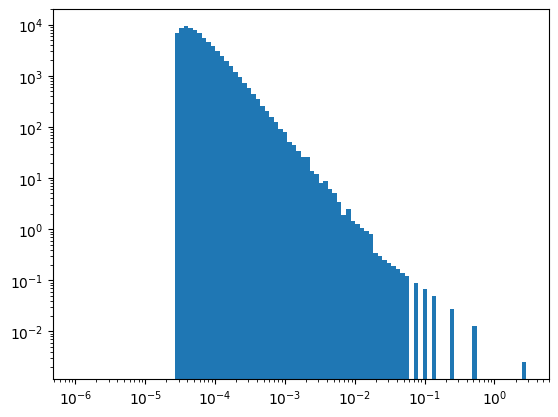

In [5]:
hist, bins = jnp.histogram(Khat_eigs[Khat_eigs > 0], bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.xscale("log")
plt.yscale("log")

In [6]:
@jit
def fixed_point_iter(z,s,t,tau):
    S_vec = 1/(1+(s/d)*D_vec)
    bSb = jnp.sum(S_vec * (btilde**2))
    u = 1/(1 + t/d)
    denom = 1-tau**2/z * d**(2*beta) * u * bSb

    s = -d/z * u - (tau**2/z**2 * d**(2*beta) * u**2 * bSb)/denom
    t = -jnp.sum(D_vec * S_vec)/z - (tau**2 * d**(2*beta)/z**2 * u * jnp.sum(D_vec * S_vec**2 * btilde**2))/denom

    return s,t

@jit
def fixed_point_solve(x,ivals,tau):
    s = 1
    t = 1
    for i in ivals:
        z = x + i*1.0j
        s,t = fixed_point_iter(z,s,t,tau)
    S_vec = 1/(1+(s/d)*D_vec)
    bSb = jnp.sum(S_vec * (btilde**2))
    u = 1/(1 + t/d)
    denom = 1-tau**2/z * d**(2*beta) * u * bSb
    tr_R = -1/z * jnp.sum(S_vec) - (tau**2/z**2 * d**(2*beta) * u * jnp.sum(S_vec**2 * btilde**2))/denom
    limit_dist = 1/jnp.pi * np.imag(tr_R) / d

    return limit_dist

In [7]:
@jit
def newton_step_m(z,m):
    S_vec = D_vec / (D_vec * m - z)
    s = jnp.sum(S_vec)
    s2 = jnp.sum(S_vec ** 2)
    f = m * (1 + s/d) - 1
    f_prime = 1 + s/d - m/d * s2
    m -= f/f_prime

    return m

@jit
def newton_solve_m(x,ivals,tau):
    m = 1
    for i in ivals:
        z = x + i*1.0j
        m = newton_step_m(z,m)
    R0 = 1/(D_vec*m-z)
    bR02b = jnp.sum(R0**2 * btilde**2)
    bR0b = jnp.sum(R0 * btilde**2)
    tr_R = jnp.sum(R0) - (tau**2 * d**(2*beta) * bR02b)/(1+tau**2 * d**(2*beta) * bR0b)
    # print("x = {}".format(x))
    # print("Im(R0) = {}".format(jnp.imag(R0)))
    # print("Trace Contribution: {}".format(jnp.imag(jnp.sum(R0)) / (jnp.pi * d)))
    # print("Spike Contribution: {}".format(jnp.imag((tau**2 * d**(2*beta) * bR02b)/(1+tau**2 * d**(2*beta) * bR0b)) / (jnp.pi * d)))
    limit_dist = 1/jnp.pi * jnp.imag(tr_R) / d

    return limit_dist

In [8]:
#Stieltjes inversion
# Next time try Newton

xvals = jnp.logspace(-6,1,num=1000)
ivals = jnp.logspace(4,-15,num=100)

limit_dist = []

for x in xvals:
   limit_dist.append(fixed_point_solve(x,ivals,tau).reshape(-1))

limit_dist = jnp.array(limit_dist)

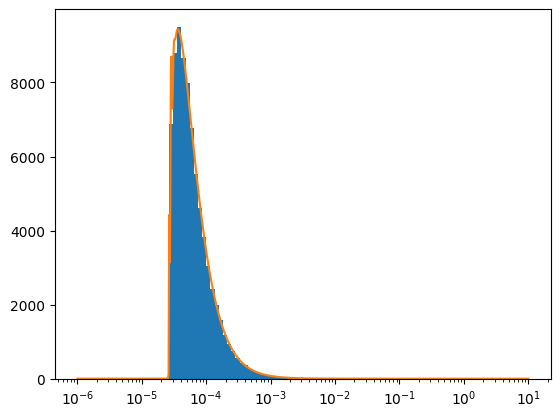

In [9]:
hist, bins = jnp.histogram(Khat_eigs, bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.plot(xvals, limit_dist)
plt.xscale('log')
#plt.yscale('log')

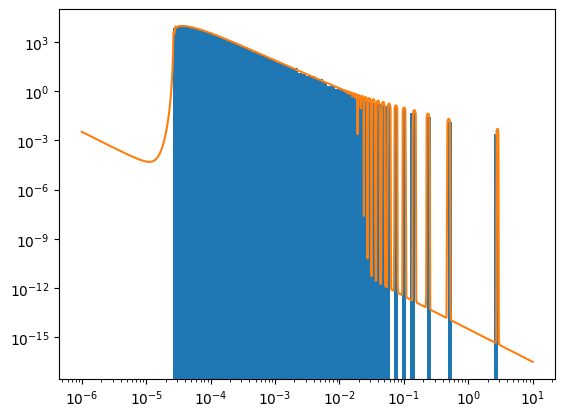

In [10]:
hist, bins = jnp.histogram(Khat_eigs, bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.plot(xvals, limit_dist)
plt.xscale('log')
plt.yscale('log')

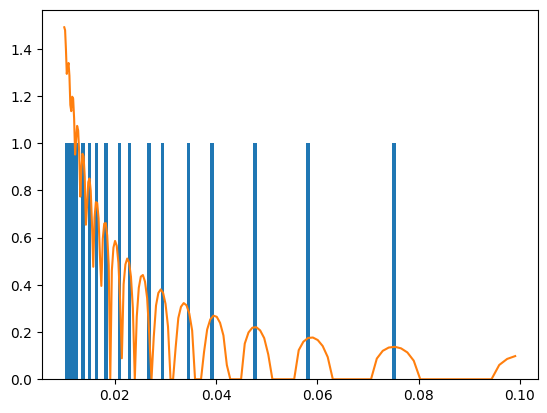

In [11]:
plt.hist(Khat_eigs[(Khat_eigs > 1e-2) * (Khat_eigs < 1e-1)], bins=100)
plt.plot(xvals[(xvals > 1e-2) * (xvals < 1e-1)], limit_dist[(xvals > 1e-2) * (xvals < 1e-1)])

In [ ]:
#Stieltjes inversion
# Next time try Newton

xvals = jnp.logspace(-6,1,num=1000)
ivals = jnp.logspace(4,-10,num=100)

tau = 0

limit_dist_zero = []

for x in xvals:
   limit_dist_zero.append(newton_solve_m(x,ivals,tau).reshape(-1))

limit_dist_zero = jnp.array(limit_dist_zero)

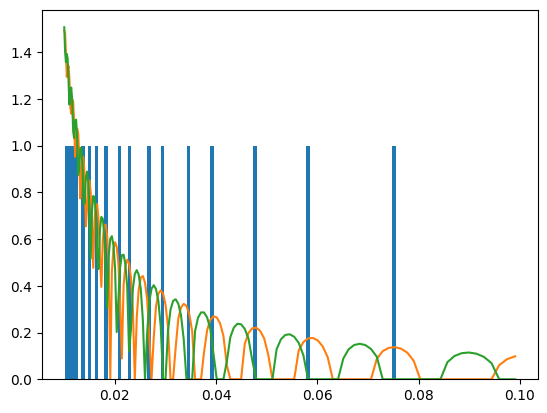

In [ ]:
# Compare to tau = 0, we see that there's no shift in the predicted spikes, but instead only a rescaling
# From the form of the Sherman-Morrison update, this actually makes sense
plt.hist(Khat_eigs[(Khat_eigs > 1e-2) * (Khat_eigs < 1e-1)], bins=100)
plt.plot(xvals[(xvals > 1e-2) * (xvals < 1e-1)], limit_dist[(xvals > 1e-2) * (xvals < 1e-1)])
plt.plot(xvals[(xvals > 1e-2) * (xvals < 1e-1)], limit_dist_zero[(xvals > 1e-2) * (xvals < 1e-1)])